In [1]:
# Other standard libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import os
import tensorflow as tf
import multiprocessing
import joblib # For saving/loading sklearn models
import gradio as gr

# TensorFlow / Keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, BatchNormalization, Dropout, Activation, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


/Users/chaotzuchieh/Documents/GitHub/project-3-TzuChieh_Chao_AML/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Original training data shape: (50000, 32, 32, 3)


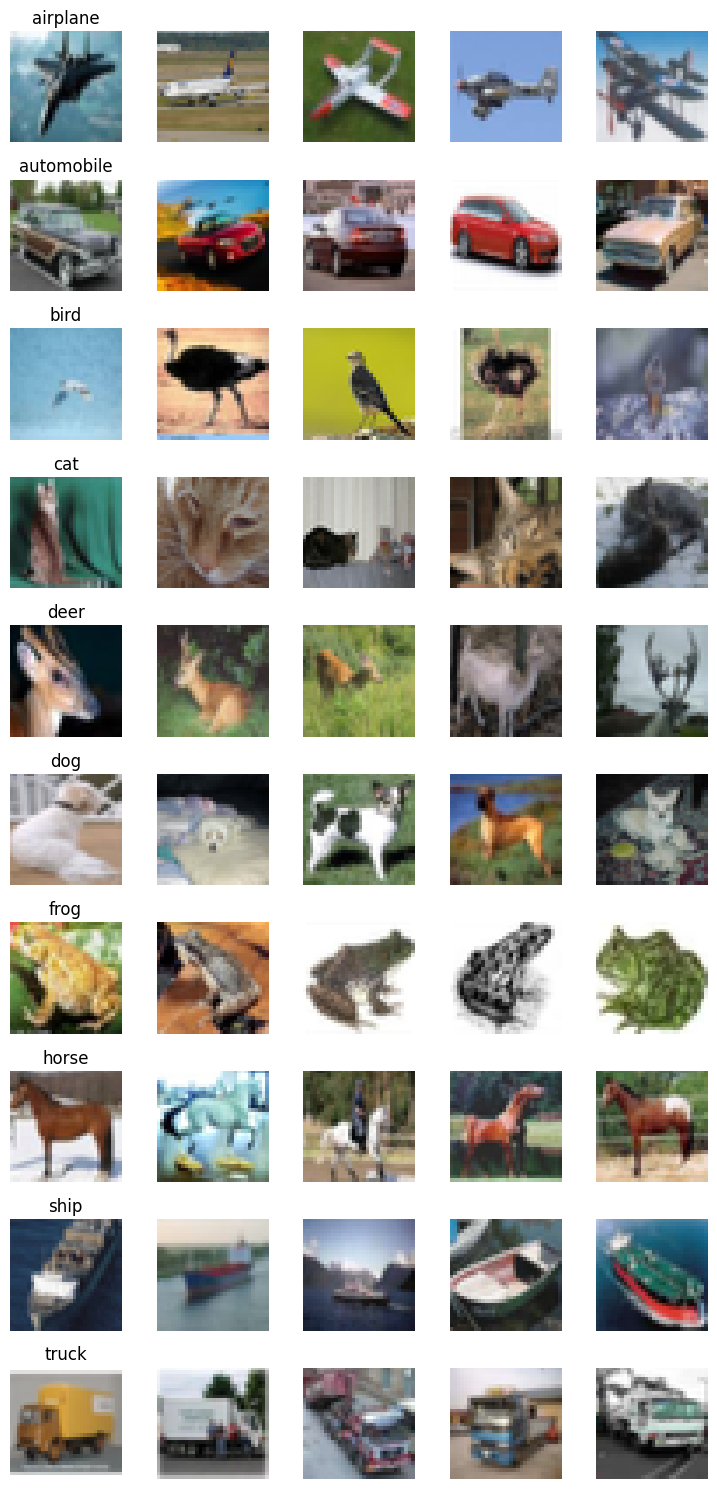

In [2]:
# Load data
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

# Class names
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]
num_classes = len(class_names)

# Visualize some samples
def visualize_cifar10_samples(X, y, class_names, samples_per_class=5, random_seed=2025):
    np.random.seed(random_seed)
    y = y.squeeze()
    plt.figure(figsize=(samples_per_class * 1.5, num_classes * 1.5))
    for cls_idx in range(num_classes):
        idxs = np.flatnonzero(y == cls_idx)
        if len(idxs) == 0: continue
        idxs = np.random.choice(idxs, min(samples_per_class, len(idxs)), replace=False)
        for i, idx in enumerate(idxs):
            plt.subplot(num_classes, samples_per_class, cls_idx * samples_per_class + i + 1)
            plt.imshow(X[idx])
            plt.axis('off')
            if i == 0:
                plt.title(class_names[cls_idx])
    plt.tight_layout()
    plt.show()

print("Original training data shape:", X_train_full.shape)
visualize_cifar10_samples(X_train_full, y_train_full, class_names, samples_per_class=5)


In [3]:
# Normalize pixel values to [0, 1]
X_train_full_norm = X_train_full.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# One-hot encode labels
y_train_full_one_hot = to_categorical(y_train_full, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)

# Create training and validation split (using the normalized data)
X_train_norm, X_val_norm, y_train_one_hot, y_val_one_hot = train_test_split(
    X_train_full_norm, y_train_full_one_hot, test_size=0.2, random_state=42, stratify=y_train_full_one_hot
)

# Keep original labels for sklearn models and some evaluations
y_train = np.squeeze(y_train_full_one_hot.argmax(axis=1)) # From one-hot back to integer labels for training split
y_val = np.squeeze(y_val_one_hot.argmax(axis=1))         # From one-hot back to integer labels for validation split
y_test_labels = np.squeeze(y_test)                       # Original test labels

print("ANN Data Shapes:")
print("X_train_norm:", X_train_norm.shape)
print("y_train_one_hot:", y_train_one_hot.shape)
print("X_val_norm:", X_val_norm.shape)
print("y_val_one_hot:", y_val_one_hot.shape)
print("X_test_norm:", X_test_norm.shape)
print("y_test_one_hot:", y_test_one_hot.shape)
print("\nSklearn Data Shapes (Labels):")
print("y_train:", y_train.shape)
print("y_val:", y_val.shape) # We'll primarily use X_test/y_test for final comparison
print("y_test_labels:", y_test_labels.shape)

ANN Data Shapes:
X_train_norm: (40000, 32, 32, 3)
y_train_one_hot: (40000, 10)
X_val_norm: (10000, 32, 32, 3)
y_val_one_hot: (10000, 10)
X_test_norm: (10000, 32, 32, 3)
y_test_one_hot: (10000, 10)

Sklearn Data Shapes (Labels):
y_train: (50000,)
y_val: (10000,)
y_test_labels: (10000,)


In [4]:
# Flatten the images and potentially scale
# Use the original 0-255 range split, then flatten and scale

# Split original data (before normalization)
X_train_orig, X_val_orig, y_train_flat, y_val_flat = train_test_split(
    X_train_full, y_train_full.squeeze(), test_size=0.2, random_state=42, stratify=y_train_full.squeeze()
)

# Flatten the image data
X_train_flat = X_train_orig.reshape(X_train_orig.shape[0], -1)
X_val_flat = X_val_orig.reshape(X_val_orig.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Scale the flattened data (important for SVM and Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)
X_test_scaled = scaler.transform(X_test_flat)

print("\nClassical Model Data Shapes:")
print("X_train_scaled (flattened):", X_train_scaled.shape)
print("X_val_scaled (flattened):", X_val_scaled.shape)
print("X_test_scaled (flattened):", X_test_scaled.shape)
print("y_train_flat (labels):", y_train_flat.shape)
print("y_val_flat (labels):", y_val_flat.shape)
print("y_test_labels (labels):", y_test_labels.shape)


Classical Model Data Shapes:
X_train_scaled (flattened): (40000, 3072)
X_val_scaled (flattened): (10000, 3072)
X_test_scaled (flattened): (10000, 3072)
y_train_flat (labels): (40000,)
y_val_flat (labels): (10000,)
y_test_labels (labels): (10000,)


In [5]:
# Define data augmentation generator (optional, can increase training time but improve robustness)
use_augmentation = False # Set to True to enable augmentation during training

if use_augmentation:
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1,
        fill_mode='nearest'
    )
    datagen.fit(X_train_norm) # Fit generator on the training data
else:
    datagen = None # No augmentation

In [6]:
### 3.1 ANN Architecture Definition
# Define a simple feed-forward ANN (MLP) or a CNN. A CNN is generally much better for image data like CIFAR-10. We will define a moderately complex CNN.
#
# **Hyperparameter Tuning Considerations:**
# * **Number of Hidden Layers:** More layers can capture more complex patterns but risk overfitting. Start with 2-3 conv blocks.
# * **Neurons per Layer:** Adjust the number of filters (Conv2D) or units (Dense). Powers of 2 (32, 64, 128) are common.
# * **Activation Functions:** 'relu' is standard for hidden layers, 'softmax' for multi-class output.
# * **Dropout:** Helps prevent overfitting. Values between 0.2 and 0.5 are common.
# * **Optimizer:** 'adam' is a good default. Others include 'RMSprop', 'SGD'. Learning rate is key.
# * **Batch Size:** Affects training speed and stability. Common values: 32, 64, 128.
# * **Epochs:** Number of passes through the training data. Use EarlyStopping to find a good number automatically.

In [7]:
def build_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    """Builds a Convolutional Neural Network model."""
    model = Sequential([
        Input(shape=input_shape),

        # Conv Block 1
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Conv Block 2
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        # Conv Block 3
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.35),

        # Fully Connected Layers
        Flatten(),
        Dense(256),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax') # Output layer
    ])
    return model

ann_model = build_cnn_model(input_shape=X_train_norm.shape[1:], num_classes=num_classes)

# Compile the model
ann_model.compile(optimizer='adam', # Starting with Adam optimizer
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

ann_model.summary()
# plot_model(ann_model, to_file='cnn_model_plot.png', show_shapes=True, show_layer_names=True) # Optional: visualize

2025-04-24 16:15:13.674397: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-04-24 16:15:13.674421: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-24 16:15:13.674428: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1745525713.674442  736482 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1745525713.674466  736482 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8, 8, 128)      │             

 Total params: 816,938 (3.12 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [8]:
# Callbacks
model_checkpoint = ModelCheckpoint('best_ann_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True) # Stop if val_loss doesn't improve for 10 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1) # Reduce LR if val_loss plateaus


In [9]:
# --- Parameters Optimized for Speed ---
epochs = 100 # Max epochs; EarlyStopping will likely stop it sooner
batch_size = 128 # Increased batch size for potentially faster processing per epoch
use_augmentation = False # Explicitly disable data augmentation

# --- Training ---
print(f"Starting training with batch_size={batch_size}, augmentation={use_augmentation}")
start_time_ann_train = time.time()

Starting training with batch_size=128, augmentation=False


In [10]:
# Train the model
# The 'if use_augmentation...' block will now be skipped because use_augmentation is False
if use_augmentation and datagen is not None:
    # This part will NOT run
    history = ann_model.fit(
        datagen.flow(X_train_norm, y_train_one_hot, batch_size=batch_size),
        steps_per_epoch=len(X_train_norm) // batch_size,
        epochs=epochs,
        validation_data=(X_val_norm, y_val_one_hot),
        callbacks=[model_checkpoint, early_stopping, reduce_lr] # Ensure these callbacks are defined earlier
    )
else:
    # This part WILL run - training without the augmentation generator overhead
    history = ann_model.fit(
        X_train_norm, y_train_one_hot,
        batch_size=batch_size, # Use the increased batch size
        epochs=epochs,
        validation_data=(X_val_norm, y_val_one_hot),
        callbacks=[model_checkpoint, early_stopping, reduce_lr] # Ensure these callbacks are defined earlier
    )


end_time_ann_train = time.time()
ann_training_time = end_time_ann_train - start_time_ann_train

print(f"\nANN Training Time: {ann_training_time:.2f} seconds")


Epoch 1/100


2025-04-24 16:15:15.740641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3120 - loss: 2.0141
Epoch 1: val_accuracy improved from -inf to 0.15480, saving model to best_ann_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.3123 - loss: 2.0131 - val_accuracy: 0.1548 - val_loss: 3.5643 - learning_rate: 0.0010
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5586 - loss: 1.2324
Epoch 2: val_accuracy improved from 0.15480 to 0.55220, saving model to best_ann_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.5587 - loss: 1.2322 - val_accuracy: 0.5522 - val_loss: 1.2472 - learning_rate: 0.0010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6470 - loss: 0.9938
Epoch 3: val_accuracy improved from 0.55220 to 0.69240, saving model to best_ann_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.6471 - loss: 0.9937 - val_accuracy: 0.6924 - val_loss: 0.8814 - learning_rate: 0.0010
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s

In [11]:
# Load the best model saved by ModelCheckpoint
print("Loading best saved model weights...")
ann_model.load_weights('best_ann_model.keras') # Keras automatically handles this with restore_best_weights=True in EarlyStopping if you prefer




Loading best saved model weights...


In [12]:
# ### 3.3 ANN Evaluation
# Evaluate on Test Set
start_time_ann_infer = time.time()
loss, accuracy = ann_model.evaluate(X_test_norm, y_test_one_hot, verbose=0)
end_time_ann_infer = time.time()
ann_inference_time_total = end_time_ann_infer - start_time_ann_infer
ann_inference_time_per_sample = ann_inference_time_total / len(X_test_norm)


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

--- ANN Performance ---
Training Accuracy (last epoch): 0.9221
Validation Accuracy (best epoch): 0.8642
Test Accuracy: 0.8640
Test F1-Score (Macro): 0.8631
Total Test Inference Time: 4.85 seconds
Average Test Inference Time per Sample: 0.4846 ms
Training Time: 2101.21 seconds

ANN Confusion Matrix:


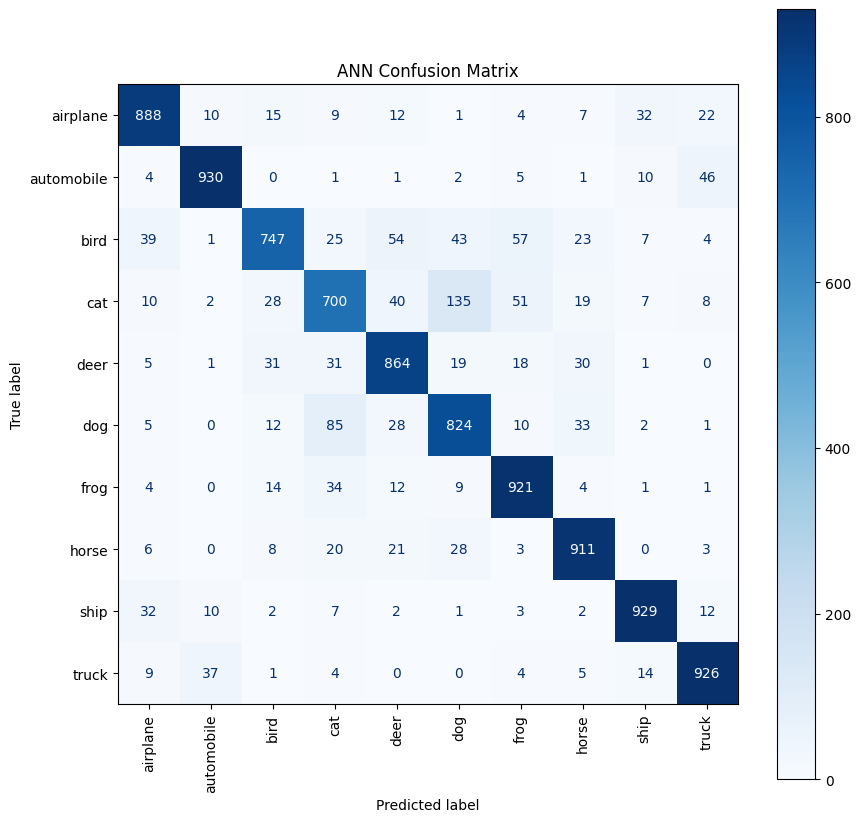


ANN Classification Report:
              precision    recall  f1-score   support

    airplane       0.89      0.89      0.89      1000
  automobile       0.94      0.93      0.93      1000
        bird       0.87      0.75      0.80      1000
         cat       0.76      0.70      0.73      1000
        deer       0.84      0.86      0.85      1000
         dog       0.78      0.82      0.80      1000
        frog       0.86      0.92      0.89      1000
       horse       0.88      0.91      0.90      1000
        ship       0.93      0.93      0.93      1000
       truck       0.91      0.93      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



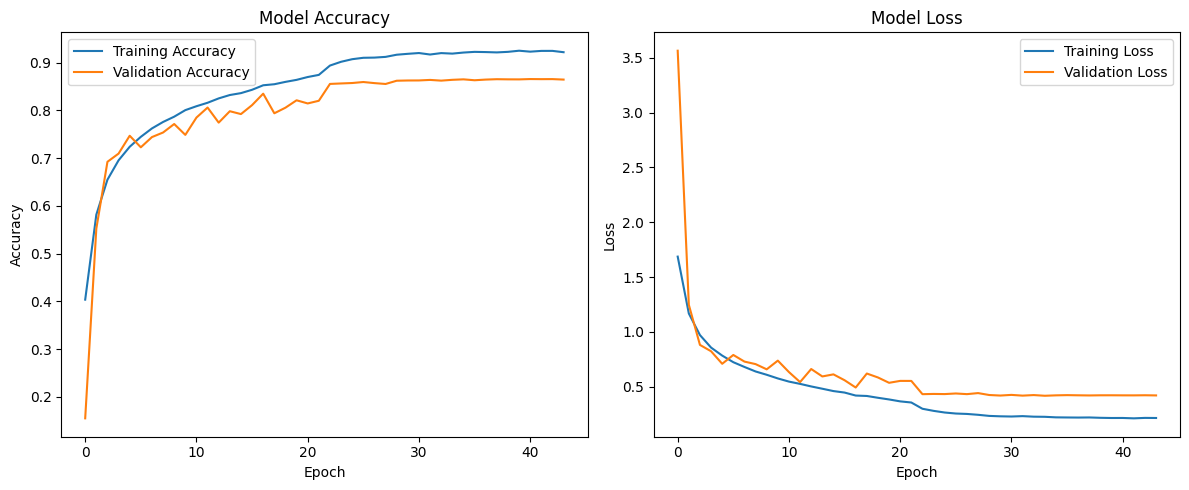

In [13]:
# Get predictions
y_pred_one_hot = ann_model.predict(X_test_norm)
y_pred_labels = np.argmax(y_pred_one_hot, axis=1)

# Calculate F1 Score (Macro)
f1_macro = f1_score(y_test_labels, y_pred_labels, average='macro')

# Get Training and Validation Accuracy from history
train_accuracy = history.history['accuracy'][-1] # Accuracy from the last epoch trained
val_accuracy = history.history['val_accuracy'][early_stopping.best_epoch] # Accuracy from the best epoch based on val_loss stopping


print("\n--- ANN Performance ---")
print(f"Training Accuracy (last epoch): {train_accuracy:.4f}")
print(f"Validation Accuracy (best epoch): {val_accuracy:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-Score (Macro): {f1_macro:.4f}")
print(f"Total Test Inference Time: {ann_inference_time_total:.2f} seconds")
print(f"Average Test Inference Time per Sample: {ann_inference_time_per_sample*1000:.4f} ms")
print(f"Training Time: {ann_training_time:.2f} seconds")


# Confusion Matrix
print("\nANN Confusion Matrix:")
cm_ann = confusion_matrix(y_test_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ann, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("ANN Confusion Matrix")
plt.show()

# Classification Report
print("\nANN Classification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=class_names))

# Plot Training History
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Store results
results = {
    'ANN': {
        'Test Accuracy': accuracy,
        'Test F1 (Macro)': f1_macro,
        'Training Time (s)': ann_training_time,
        'Avg Inference Time (ms)': ann_inference_time_per_sample * 1000
    }
}


--- Loading Classical Models (No PCA) from Project 2 ---
Successfully loaded non-PCA models.

Fitting StandardScaler on the current training data split...
Scaler fitted and data transformed.

--- Evaluating Loaded Classical Models (No PCA) ---

Evaluating Logistic Regression...
Logistic Regression Test Accuracy: 0.3257
Logistic Regression Test F1 (Macro): 0.3183
Logistic Regression Training Time: N/A (Loaded Model)
Logistic Regression Avg Inference Time: 0.0124 ms

Logistic Regression Confusion Matrix (No PCA):


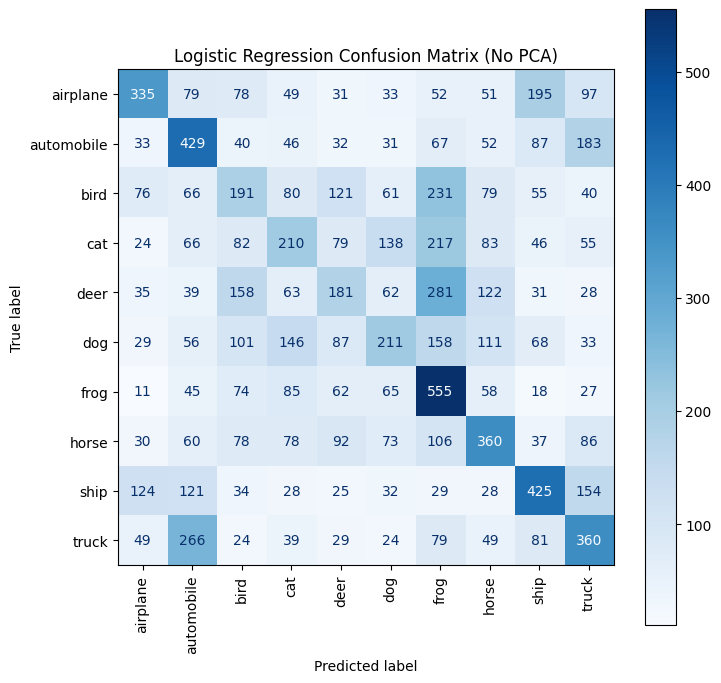


Evaluating Random Forest...
Random Forest Test Accuracy: 0.2994
Random Forest Test F1 (Macro): 0.2771
Random Forest Training Time: N/A (Loaded Model)
Random Forest Avg Inference Time: 0.0313 ms

Random Forest Confusion Matrix (No PCA):


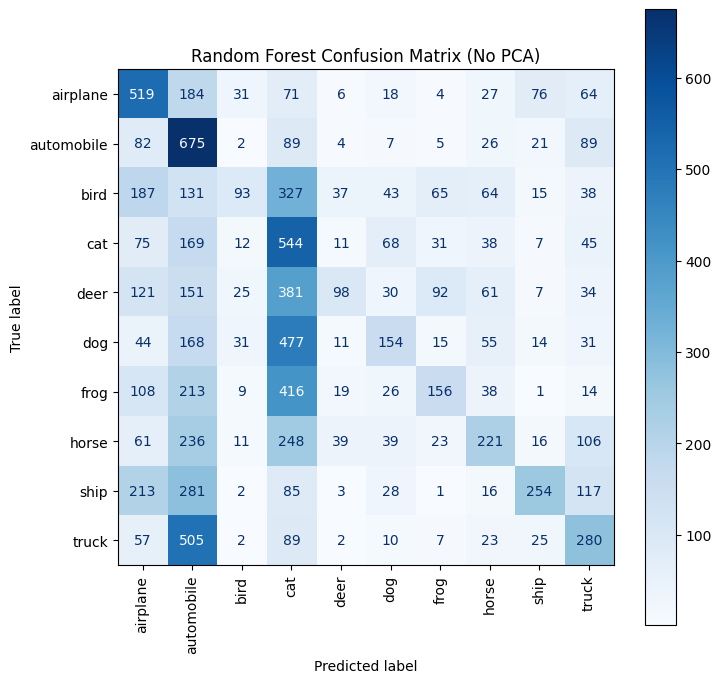


Evaluating SVM...
SVM Test Accuracy: 0.1001
SVM Test F1 (Macro): 0.0184
SVM Training Time: N/A (Loaded Model)
SVM Avg Inference Time: 3.4671 ms

SVM Confusion Matrix (No PCA):


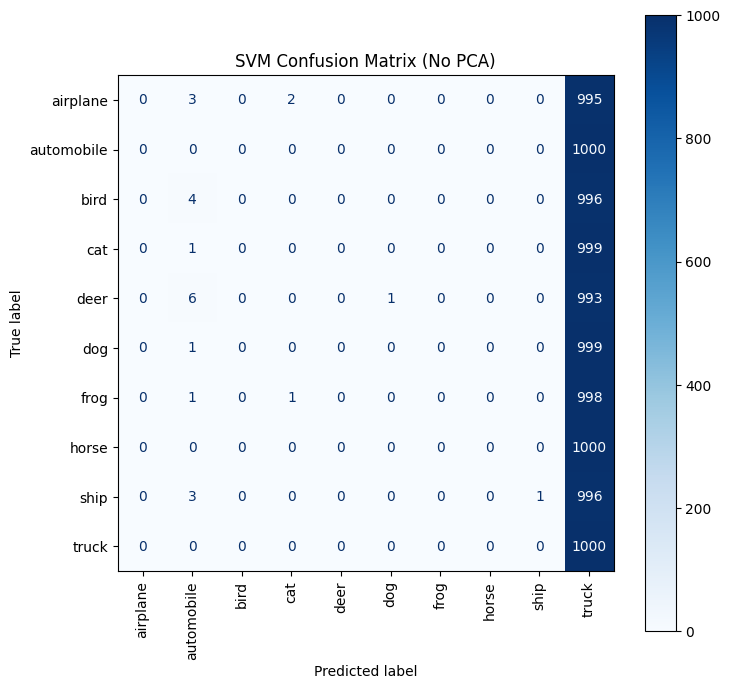


--- Loading PCA Transformer and Models from Project 2 ---
Successfully loaded PCA-based models.

--- Evaluating Loaded Classical Models (With PCA) ---
Skipping PCA model evaluation as models or transformer could not be loaded.

--- Comparison Summary ---
Model                          | Test Acc   | Test F1 (Macro) | Train Time (s)  | Avg Inference (ms)  
-----------------------------------------------------------------------------------------------
ANN                            | 0.8640      | 0.8631           | 2101.21         | 0.4846
Logistic Regression_NoPCA      | 0.3257      | 0.3183           | N/A             | 0.0124
Random Forest_NoPCA            | 0.2994      | 0.2771           | N/A             | 0.0313
SVM_NoPCA                      | 0.1001      | 0.0184           | N/A             | 3.4671


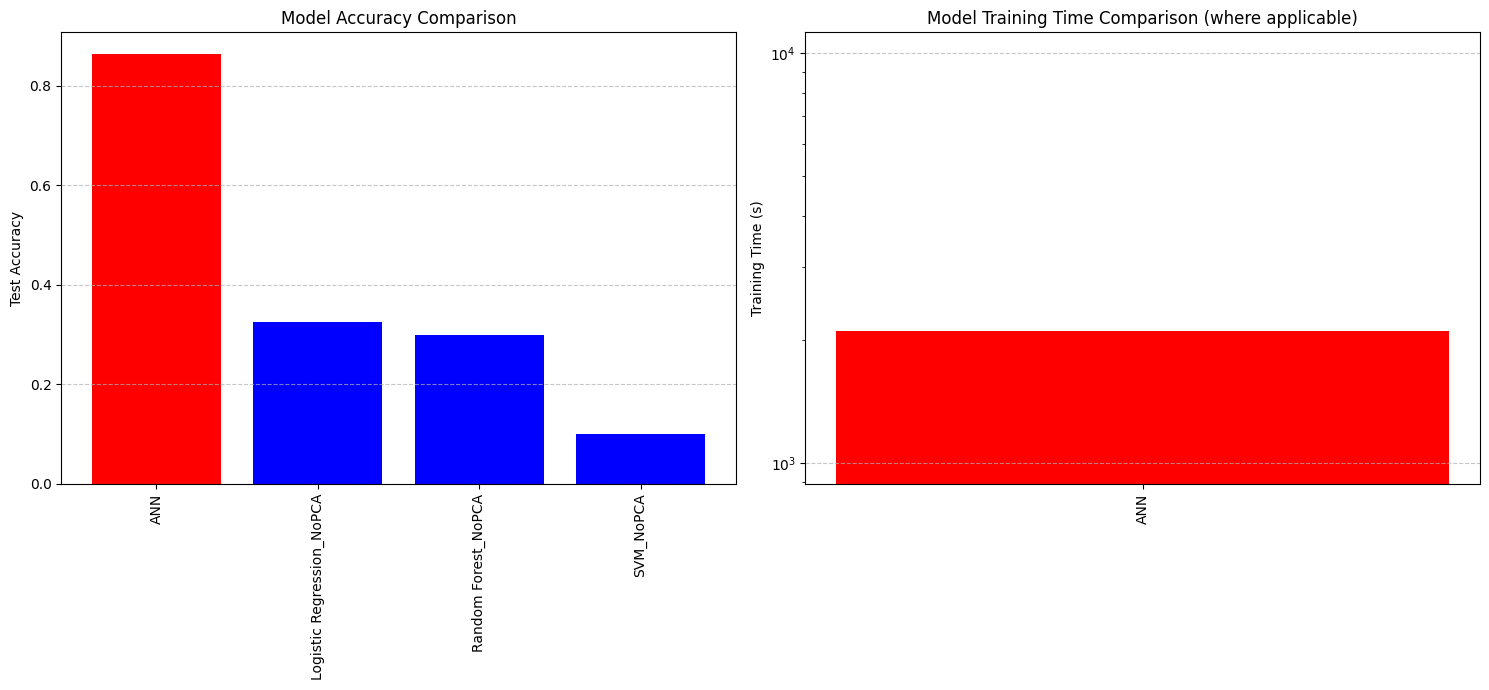

In [14]:

# ## 4. Task 2: Compare with Classical Models
# Load and evaluate the best-performing models saved from Project 2.
# --- Load Project 2 Models (No PCA) ---
# NOTE: Adjust paths if the .pkl files are not in the current directory
print("\n--- Loading Classical Models (No PCA) from Project 2 ---")
try:
    # Load models saved in training_Project2 .ipynb
    lr_model_no_pca = joblib.load('best_lr_model.pkl')
    rf_model_no_pca = joblib.load('best_rf_model.pkl')
    svc_model_no_pca = joblib.load('best_SVC_model.pkl') # Note the filename difference from test notebook

    models_loaded_no_pca = {
        "Logistic Regression": lr_model_no_pca,
        "Random Forest": rf_model_no_pca,
        "SVM": svc_model_no_pca
    }
    print("Successfully loaded non-PCA models.")
except FileNotFoundError as e:
    print(f"Error loading non-PCA models: {e}")
    print("Please ensure the .pkl files (best_lr_model.pkl, best_rf_model.pkl, best_SVC_model.pkl) are in the correct directory.")
    models_loaded_no_pca = {} # Set to empty if loading fails
except Exception as e:
    print(f"An unexpected error occurred loading non-PCA models: {e}")
    models_loaded_no_pca = {}


# --- Scaler Consistency ---
# Re-fit scaler on the current training data split as it wasn't explicitly saved
print("\nFitting StandardScaler on the current training data split...")
scaler = StandardScaler()
# Ensure X_train_flat and y_train_flat are available from Section 2.2
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat) # Use the same scaler to transform test data
print("Scaler fitted and data transformed.")


# --- Evaluation without Dimensionality Reduction ---
print("\n--- Evaluating Loaded Classical Models (No PCA) ---")

# Ensure the results dictionary exists from ANN evaluation
if 'results' not in locals():
    results = {}

if not models_loaded_no_pca:
     print("Skipping non-PCA model evaluation as models could not be loaded.")
else:
    for name, model in models_loaded_no_pca.items():
        print(f"\nEvaluating {name}...")
        # Training time is not applicable here as we loaded pre-trained models
        train_time = np.nan # Or 0 or a placeholder indicating pre-trained

        start_infer_time = time.time()
        # Predict on the scaled, flattened test data from *this* notebook's split
        # Ensure y_test_labels is available from Section 2.1/2.2
        y_pred = model.predict(X_test_scaled)
        end_infer_time = time.time()
        infer_time_total = end_infer_time - start_infer_time
        infer_time_per_sample = infer_time_total / len(X_test_scaled)

        accuracy = accuracy_score(y_test_labels, y_pred)
        f1 = f1_score(y_test_labels, y_pred, average='macro')

        print(f"{name} Test Accuracy: {accuracy:.4f}")
        print(f"{name} Test F1 (Macro): {f1:.4f}")
        print(f"{name} Training Time: N/A (Loaded Model)")
        print(f"{name} Avg Inference Time: {infer_time_per_sample*1000:.4f} ms")

        # Store results
        results[f"{name}_NoPCA"] = {
            'Test Accuracy': accuracy,
            'Test F1 (Macro)': f1,
            'Training Time (s)': train_time, # Indicate N/A
            'Avg Inference Time (ms)': infer_time_per_sample * 1000
        }

        print(f"\n{name} Confusion Matrix (No PCA):")
        cm = confusion_matrix(y_test_labels, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # Ensure class_names is defined
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
        plt.title(f"{name} Confusion Matrix (No PCA)")
        plt.show()


# %% [markdown]
# ### 4.1 Classical Models with Dimensionality Reduction (PCA)
# Load the saved PCA transformer and the models trained on PCA-reduced data from Project 2.

# %% [code]
# --- Load PCA Transformer and Models ---
print("\n--- Loading PCA Transformer and Models from Project 2 ---")


# Load models trained with PCA saved in Project 2 - Dimensionality Reduction.ipynb
lr_model_pca = joblib.load('best_pca_lr_grid_model.pkl')
rf_model_pca = joblib.load('best_pca_rf_grid_model.pkl')
svc_model_pca = joblib.load('best_pca_svc_model.pkl') # Used grid suffix based on saving notebook

models_loaded_pca = {
        "Logistic Regression": lr_model_pca,
        "Random Forest": rf_model_pca,
        "SVM": svc_model_pca
    }
print("Successfully loaded PCA-based models.")




# --- Evaluation with PCA ---
print("\n--- Evaluating Loaded Classical Models (With PCA) ---")

if not models_loaded_pca is None:
    print("Skipping PCA model evaluation as models or transformer could not be loaded.")
else:
    # Apply the loaded PCA transformation to the scaled test data
    print(f"Applying loaded PCA transformation (n_components={pca.n_components_})...")
    # X_test_scaled should be available from the previous cell
    X_test_pca = pca.transform(X_test_scaled)
    print(f"Shape after PCA transformation: {X_test_pca.shape}")

    for name, model in models_loaded_pca.items():
        print(f"\nEvaluating {name} with PCA...")
        train_time = np.nan # Pre-trained

        start_infer_time = time.time()
        # Predict on the PCA-transformed test data
        y_pred = model.predict(X_test_pca)
        end_infer_time = time.time()
        infer_time_total = end_infer_time - start_infer_time
        infer_time_per_sample = infer_time_total / len(X_test_pca)

        accuracy = accuracy_score(y_test_labels, y_pred)
        f1 = f1_score(y_test_labels, y_pred, average='macro')

        print(f"{name}_PCA Test Accuracy: {accuracy:.4f}")
        print(f"{name}_PCA Test F1 (Macro): {f1:.4f}")
        print(f"{name}_PCA Training Time: N/A (Loaded Model)")
        print(f"{name}_PCA Avg Inference Time: {infer_time_per_sample*1000:.4f} ms")

        # Store results
        results[f"{name}_PCA"] = {
            'Test Accuracy': accuracy,
            'Test F1 (Macro)': f1,
            'Training Time (s)': train_time, # Indicate N/A
            'Avg Inference Time (ms)': infer_time_per_sample * 1000
        }


# %% [markdown]
# ### 4.2 Comparison Summary

# %% [code]
# Display results in a table-like format
print("\n--- Comparison Summary ---")
# Make sure the results dict includes the ANN results from Task 1
if not results:
     print("Results dictionary is empty. Cannot generate summary.")
else:
    print(f"{'Model':<30} | {'Test Acc':<10} | {'Test F1 (Macro)':<15} | {'Train Time (s)':<15} | {'Avg Inference (ms)':<20}")
    print("-" * 95)
    # Sort results for consistent order (optional) - ANN first, then others
    sorted_names = sorted(results.keys(), key=lambda x: (x != 'ANN', 'NoPCA' not in x, x))

    for name in sorted_names:
        metrics = results[name]
        train_time_str = f"{metrics['Training Time (s)']:.2f}" if not np.isnan(metrics['Training Time (s)']) else "N/A"
        print(f"{name:<30} | {metrics['Test Accuracy']:.4f}{' ':<5} | {metrics['Test F1 (Macro)']:.4f}{' ':<10} | {train_time_str:<15} | {metrics['Avg Inference Time (ms)']:.4f}")

    # Visualize this comparison too, e.g., using bar charts
    # Example: Bar chart for Accuracy
    names = sorted_names # Use the sorted names
    accuracies = [results[name]['Test Accuracy'] for name in names]
    # Exclude N/A training times for plotting
    times_valid = {name: metrics['Training Time (s)'] for name, metrics in results.items() if not np.isnan(metrics['Training Time (s)'])}
    names_time = list(times_valid.keys())
    times = list(times_valid.values())


    fig, ax = plt.subplots(1, 2, figsize=(15, 7)) # Adjusted figure size

    # Color mapping for clarity
    colors = []
    for name in names:
        if 'ANN' in name: colors.append('red')
        elif '_NoPCA' in name: colors.append('blue')
        elif '_PCA' in name: colors.append('green')
        else: colors.append('gray') # Fallback

    ax[0].bar(names, accuracies, color=colors)
    ax[0].set_ylabel('Test Accuracy')
    ax[0].set_title('Model Accuracy Comparison')
    ax[0].tick_params(axis='x', rotation=90)
    ax[0].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot only models with valid training time
    if names_time:
         colors_time = []
         for name in names_time:
             if 'ANN' in name: colors_time.append('red')
             elif '_NoPCA' in name: colors_time.append('blue')
             elif '_PCA' in name: colors_time.append('green')
             else: colors_time.append('gray')
         ax[1].bar(names_time, times, color=colors_time)
         ax[1].set_ylabel('Training Time (s)')
         ax[1].set_title('Model Training Time Comparison (where applicable)')
         ax[1].tick_params(axis='x', rotation=90)
         # Optional: Use log scale if times vary greatly, check if times are positive
         if all(t > 0 for t in times):
              ax[1].set_yscale('log')
         ax[1].grid(axis='y', linestyle='--', alpha=0.7)
    else:
         ax[1].text(0.5, 0.5, 'No valid training times to plot', ha='center', va='center')
         ax[1].set_title('Model Training Time Comparison')


    plt.tight_layout()
    plt.show()

In [15]:
import tensorflow as tf
import numpy as np
from PIL import Image
import pandas as pd
import os
import zipfile # Import the zipfile module
import io      # Import the io module

# Path to the uploaded ZIP file (adjust if necessary)
# Assuming the ZIP file is in the current working directory or provide the full path
zip_file_path = "cifar10_test_images.zip"

# --- Check if the ZIP file exists ---
if not os.path.exists(zip_file_path):
    print(f"Error: ZIP file not found at {zip_file_path}")
    # Exit or handle the error appropriately
    exit()
# ----------------------------------

# Load trained model (adjust if your model file is named differently)
# Make sure 'best_ann_model.keras' is accessible
model_path = 'best_ann_model.keras'
if not os.path.exists(model_path):
    print(f"Error: Model file not found at {model_path}")
    exit()
model = tf.keras.models.load_model(model_path)


# Prepare prediction list
predictions = []
image_ids = []

# --- Open the ZIP file ---
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zf:
        # Get list of files in ZIP to check structure (optional but good practice)
        # file_list = zf.namelist()
        # print("Files in zip:", file_list[:10]) # Print first 10 files to check paths

        # Loop through image numbers 1 to 10000
        for i in range(1, 10001):
            # Construct the expected filename *inside* the zip archive
            # IMPORTANT: Adjust this path if the images are inside a folder within the zip
            # Example 1: Images directly in zip -> filename = f"{i:04d}.png"
            # Example 2: Images in 'cifar10_test_images' folder inside zip -> filename_in_zip = f"cifar10_test_images/{i:04d}.png"
            # --- Assuming structure is folder/image.png ---
            filename_base = f"{i:04d}.png"
            # Try common folder names or adjust as needed
            possible_paths = [
                 f"cifar10_test_images/{filename_base}", # Common case if folder was zipped
                 filename_base # If images are at the root of the zip
            ]

            img_data = None
            actual_filename_in_zip = None
            for potential_path in possible_paths:
                 try:
                     # Read image data from the zip file
                     img_data = zf.read(potential_path)
                     actual_filename_in_zip = potential_path
                     break # Found the image, stop checking paths
                 except KeyError:
                     continue # Try the next possible path

            if img_data is None:
                print(f"Warning: Image {filename_base} not found in zip at expected paths.")
                # Decide how to handle missing images: skip, add placeholder, etc.
                # Skipping for now:
                continue # Skip to the next image


            # --- Load and preprocess image from zip data ---
            # Use io.BytesIO to treat the bytes read from zip as a file
            img_stream = io.BytesIO(img_data)
            img = Image.open(img_stream).resize((32, 32)) # Ensure 32x32

            img_array = np.array(img)

            # Handle Grayscale images if they exist (CIFAR-10 is usually RGB)
            if len(img_array.shape) == 2: # Grayscale image
                 # Convert grayscale to RGB by stacking the channel
                 img_array = np.stack((img_array,) * 3, axis=-1)
                 print(f"Converted grayscale image {filename_base} to RGB")
            elif img_array.shape[2] == 4: # RGBA image
                 # Remove alpha channel
                 img_array = img_array[:, :, :3]
                 print(f"Removed alpha channel from image {filename_base}")

            # Ensure the image array is suitable for the model (e.g., 3 channels)
            if img_array.shape != (32, 32, 3):
                 print(f"Warning: Image {filename_base} has unexpected shape {img_array.shape}. Skipping.")
                 continue

            img_array = img_array / 255.0 # Normalize
            img_array = np.expand_dims(img_array, axis=0) # Add batch dimension


            # --- Predict ---
            pred = model.predict(img_array, verbose=0)
            predicted_class = np.argmax(pred)

            image_ids.append(f"{i:04d}")
            predictions.append(predicted_class)

except zipfile.BadZipFile:
    print(f"Error: The file {zip_file_path} is not a valid ZIP file or is corrupted.")
    exit()
except FileNotFoundError:
     print(f"Error: ZIP file not found at {zip_file_path}")
     exit()


# --- Save CSV ---
if image_ids: # Check if any predictions were made
    submission_df = pd.DataFrame({
        "ID": image_ids,
        "PredictedLabel": predictions
    })

    submission_df.to_csv("TzuChieh_section2_submission.csv", index=False)
    print(f"Prediction complete! CSV file 'TzuChieh_section2_submission.csv' created with {len(image_ids)} predictions.")
else:
    print("Prediction failed. No images were processed successfully.")

Prediction complete! CSV file 'TzuChieh_section2_submission.csv' created with 10000 predictions.


## Gradio

## On Website

In [2]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
import os
import traceback # Import traceback for detailed error printing
import time # Optional: to keep script alive

# --- Configuration ---
# IMPORTANT: Make sure this path points correctly to your model file
MODEL_PATH = 'best_ann_model.keras'

# Define CIFAR-10 class names (ensure order matches model's training output)
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
NUM_CLASSES = len(CLASS_NAMES)
# --- End Configuration ---

# --- Load Model ---
ann_model_loaded = None # Initialize as None
print(f"Attempting to load model from: {MODEL_PATH}")
try:
    # Check if the model file exists before trying to load
    if not os.path.exists(MODEL_PATH):
        print(f"Error: Model file not found at '{MODEL_PATH}'")
    else:
        ann_model_loaded = load_model(MODEL_PATH)
        # Let's print the model summary to confirm its input layer shape
        print("Model Summary:")
        ann_model_loaded.summary()
        print("\nANN model loaded successfully for Gradio interface.")
        # Verify the expected input shape from the loaded model
        try:
            expected_shape = ann_model_loaded.input_shape
            print(f"Model expects input shape: {expected_shape}")
            # Check if the expected shape is indeed (None, 32, 32, 3)
            if expected_shape != (None, 32, 32, 3):
                print(f"Warning: Model input shape {expected_shape} is not the expected (None, 32, 32, 3).")
                print("The code has been adjusted for (None, 32, 32, 3) based on the error message.")
                print("If the model truly expects a different shape, adjust the 'prediction_input' preparation accordingly.")
        except Exception as e:
            print(f"Could not automatically determine model input shape: {e}")

except Exception as e:
    print(f"Error loading Keras model: {e}")
    print(f"Please ensure '{MODEL_PATH}' exists and is a valid Keras model file.")
    traceback.print_exc() # Print detailed error
# --- End Load Model ---

# --- Prediction Function ---
def predict_image(input_img):
    if ann_model_loaded is None:
        print("Error: predict_image called but model is not loaded.")
        return {"Error": "Model not loaded. Please check logs."}
    if input_img is None:
        print("Input image is None.")
        return {"Error": "No input image provided."}
    try:
        # Ensure input is a PIL Image (Gradio's gr.Image(type='pil') should handle this)
        if not isinstance(input_img, Image.Image):
             # Convert numpy array from Gradio Sketchpad/Image editor if needed
            if isinstance(input_img, np.ndarray):
                print("Converting numpy array input to PIL Image.")
                input_img = Image.fromarray(input_img.astype('uint8'), 'RGB')
            else:
                print(f"Warning: Expected PIL Image or NumPy array, received {type(input_img)}. Cannot process.")
                return {"Error": f"Invalid input type: {type(input_img)}"}

        # Preprocess the image: resize, convert to RGB, normalize
        img = input_img.resize((32, 32)).convert('RGB')
        img_array = np.array(img).astype('float32')
        img_array = img_array / 255.0 # Normalize to [0, 1]

        # Verify shape after preprocessing
        if img_array.shape != (32, 32, 3):
            print(f"Error: Incorrect image shape after conversion: Got {img_array.shape}, Expected (32, 32, 3)")
            return {f"Error": f"Incorrect image shape after conversion: Got {img_array.shape}, Expected (32, 32, 3)"}

        # *** Prepare Input based on the corrected understanding of the model's expected shape ***
        # The error message indicated the model expects (None, 32, 32, 3).
        # We need to add the batch dimension (axis=0) to our single image array.

        # OPTION 1: For ANN expecting flattened input (Incorrect based on error message)
        # prediction_input = img_array.reshape(1, -1) # Shape (1, 3072) <- DO NOT USE THIS

        # OPTION 2: For models expecting image format input (Correct based on error message)
        prediction_input = np.expand_dims(img_array, axis=0) # Shape (1, 32, 32, 3) <- USE THIS

        print(f"Prepared prediction input with shape: {prediction_input.shape}") # Add log to confirm shape

        # Make prediction
        predictions = ann_model_loaded.predict(prediction_input)[0] # Get predictions for the first (only) image

        # Verify prediction output length
        if len(predictions) != NUM_CLASSES:
            print(f"Error: Model output size ({len(predictions)}) does not match NUM_CLASSES ({NUM_CLASSES}).")
            return {"Error": "Model output size mismatch. Check model definition."}

        # Format output for Gradio Label component
        confidences = {CLASS_NAMES[i]: float(predictions[i]) for i in range(NUM_CLASSES)}
        return confidences

    except Exception as e:
        print(f"Error during image processing or prediction: {e}")
        traceback.print_exc() # Print detailed traceback for debugging
        # Return a user-friendly error message, avoiding overly technical details if possible
        return {"Error": f"Processing Error. Check server logs for details."}
# --- End Prediction Function ---


# --- Create and Launch Gradio Interface ---
if ann_model_loaded:
    print("\nModel loaded. Creating Gradio interface...")
    try:
        iface = gr.Interface(
            fn=predict_image,
            # Use gr.Image which allows upload, webcam, or drawing/editing. type='pil' is good.
            inputs=gr.Image(type="pil", label="Upload Image, Use Webcam, or Draw (resized to 32x32)"),
            outputs=gr.Label(num_top_classes=NUM_CLASSES, label="Prediction Confidence"),
            # Consider updating title/description if model isn't a simple ANN
            title="CIFAR-10 Image Classifier",
            description="Upload an image, use webcam, or draw one. Classified using a trained model. Model expects input shape (1, 32, 32, 3).",
            examples=[] # You can add paths to example images here if desired
        )

        print("\nLaunching Gradio Interface...")
        print("This will provide a public URL (link) to access the interface if share=True.")

        # Launch the interface:
        # share=True: Creates a public link (requires internet connection, expires)
        # inline=False: Prevents trying to embed in notebooks if running as a script
        # debug=True: Provides more detailed errors in the browser console (useful during development)
        iface.launch(share=True, inline=False, debug=True) # Set debug=True for easier troubleshooting

        print("\nGradio Interface Launched. Access it via the local or public URL provided above.")
        print("This script needs to keep running on the server for the interface to work.")
        print("Stop the script (e.g., Ctrl+C in terminal or stop button in Jupyter) to quit.")

        # Keep the script running so the Gradio server stays active
        # This simple loop prevents the script from exiting immediately.
        # In a real deployment, you might use a more robust method.
        print("Keeping script alive (Press Ctrl+C to stop)...")
        while True:
            time.sleep(3600) # Sleep for 1 hour, then loop again (or just time.sleep(1) is fine)

    except Exception as e:
        print(f"\nError creating or launching Gradio interface: {e}")
        traceback.print_exc() # Print detailed traceback

else:
    print("\n--- Gradio interface cannot be launched because the model failed to load. ---")
    print(f"Please ensure the model file '{MODEL_PATH}' exists, is accessible, and is a valid Keras model.")

print("\nScript finished (or was interrupted).")
       

Attempting to load model from: best_ann_model.keras
Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8, 8, 128)      │             

 Total params: 2,448,000 (9.34 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

 Optimizer params: 1,631,062 (6.22 MB)


ANN model loaded successfully for Gradio interface.
Model expects input shape: (None, 32, 32, 3)

Model loaded. Creating Gradio interface...

Launching Gradio Interface...
This will provide a public URL (link) to access the interface if share=True.
* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://63ee147297d9850e67.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://2f5c6e37a21885ad81.gradio.live
Killing tunnel 127.0.0.1:7861 <> https://63ee147297d9850e67.gradio.live

Gradio Interface Launched. Access it via the local or public URL provided above.
This script needs to keep running on the server for the interface to work.
Stop the script (e.g., Ctrl+C in terminal or stop button in Jupyter) to q

KeyboardInterrupt: 

## On notebook

In [1]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
import os
import traceback # Import traceback for detailed error printing

# --- Configuration ---
# IMPORTANT: Make sure this path points correctly to your model file
# If it's in Google Drive, use the full path like '/content/drive/MyDrive/your_folder/best_ann_model.keras'
MODEL_PATH = 'best_ann_model.keras'

# Define CIFAR-10 class names (ensure order matches model's training output)
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
NUM_CLASSES = len(CLASS_NAMES)
# --- End Configuration ---

# --- Load Model ---
ann_model_loaded = None # Initialize as None
print(f"Attempting to load model from: {MODEL_PATH}")
try:
    # Check if the model file exists before trying to load
    if not os.path.exists(MODEL_PATH):
        print(f"Error: Model file not found at '{MODEL_PATH}'")
    else:
        ann_model_loaded = load_model(MODEL_PATH)
        print("Model loaded successfully for Gradio interface.")
        # Optional: Uncomment to see model structure and confirm input shape
        # print("Model Summary:")
        # ann_model_loaded.summary()
        # try:
        #     print(f"Loaded model expects input shape: {ann_model_loaded.input_shape}")
        # except Exception as e:
        #     print(f"Could not automatically determine model input shape: {e}")

except Exception as e:
    print(f"Error loading Keras model: {e}")
    print(f"Please ensure '{MODEL_PATH}' exists and is a valid Keras model file.")
    traceback.print_exc() # Print detailed error
# --- End Load Model ---

# --- Prediction Function ---
def predict_image(input_img):
    # Check if model loaded successfully
    if ann_model_loaded is None:
        print("Error: predict_image called but model is not loaded.")
        return {"Error": "Model not loaded. Please check logs."}

    # Check if input is provided
    if input_img is None:
        print("Input image is None.")
        return {"Error": "No input image provided."}

    try:
        # Ensure input is a PIL Image (Gradio default for gr.Image)
        if not isinstance(input_img, Image.Image):
             # Convert numpy array from Gradio Sketchpad/Image editor if needed
            if isinstance(input_img, np.ndarray):
                print("Converting numpy array input to PIL Image.")
                input_img = Image.fromarray(input_img.astype('uint8'), 'RGB')
            else:
                print(f"Warning: Expected PIL Image or NumPy array, received {type(input_img)}. Cannot process.")
                return {"Error": f"Invalid input type: {type(input_img)}"}

        # Resize image to 32x32 (standard for CIFAR) and ensure RGB
        img = input_img.resize((32, 32)).convert('RGB')

        # Convert PIL Image to numpy array for preprocessing
        img_array = np.array(img).astype('float32')

        # --- Image Preprocessing ---
        # 1. Normalize pixel values to [0, 1]
        img_array = img_array / 255.0

        # 2. Check shape after conversion and normalization (should be 32, 32, 3)
        if img_array.shape != (32, 32, 3):
             return {f"Error": f"Incorrect image shape after conversion: Got {img_array.shape}, Expected (32, 32, 3)"}

        # 3. *** Prepare Input for the Specific Model Type ***
        #    Based on previous errors, the model likely expects the image format (1, 32, 32, 3).
        prediction_input = np.expand_dims(img_array, axis=0) # Shape (1, 32, 32, 3)
        expected_input_shape_str = "(1, 32, 32, 3)" # For messages/debugging

        # --- Make Prediction ---
        # print(f"Debug: Input shape to model: {prediction_input.shape}") # Uncomment for debugging shape
        predictions = ann_model_loaded.predict(prediction_input)[0] # Get prediction vector

        # Check if the number of predictions matches the number of classes
        if len(predictions) != NUM_CLASSES:
             print(f"Error: Model output size ({len(predictions)}) does not match NUM_CLASSES ({NUM_CLASSES}).")
             return {"Error": "Model output size mismatch. Check model definition."}

        # --- Format Output for gr.Label ---
        # Create a dictionary mapping class names to confidence scores
        confidences = {CLASS_NAMES[i]: float(predictions[i]) for i in range(NUM_CLASSES)}

        # Return the dictionary. gr.Label will display it nicely.
        return confidences

    except Exception as e:
        # Catch any other errors during processing/prediction
        print(f"Error during image processing or prediction: {e}")
        traceback.print_exc() # Print detailed error stack
        # Provide a user-friendly error message in the output component
        return {"Error": f"Processing Error. Check logs: {e}"}
# --- End Prediction Function ---


# --- Create and Launch Gradio Interface ---
# Only attempt to create the interface if the model loaded successfully
if ann_model_loaded:
    print("\nModel loaded. Creating Gradio interface...")
    iface = gr.Interface(
        fn=predict_image,
        # Input: Use gr.Image with type="pil". Handles uploads & drawing canvas.
        inputs=gr.Image(type="pil", label="Upload Image or Draw (resized to 32x32)"),
        # Output: Use gr.Label. It automatically handles dictionaries.
        outputs=gr.Label(num_top_classes=NUM_CLASSES, label="Prediction Confidence"), # Show all classes
        title="CIFAR-10 Image Classifier", # Removed (ANN) ambiguity
        description="Upload an image or draw one. The image will be resized to 32x32 and classified into one of the 10 CIFAR-10 categories. (Model expects input shape (1, 32, 32, 3)).", # Updated description
        examples=[] # Optional: Add example image paths if needed
    )

    # Launch the interface to run inline in the notebook
    print("Launching Gradio Interface directly in the notebook...")
    try:
        # inline=True makes it appear in the cell output
        # share=True is often helpful/needed in Colab/remote environments
        iface.launch(share=True, inline=True, debug=False)
    except Exception as e:
        print(f"\nError launching Gradio interface: {e}")
        traceback.print_exc() # Print detailed error
        print("Check for network issues or potential conflicts if problems persist.")

else:
    # Message if the model didn't load
    print("\n--- Gradio interface cannot be launched because the model failed to load. ---")
    print(f"Please ensure the model file '{MODEL_PATH}' exists and is accessible.")
# --- End Gradio Interface ---

# No 'while True' loop is needed when running inline=True in a notebook.
print("\nScript execution complete. Gradio interface (if launched) is embedded above.")

/Users/chaotzuchieh/Documents/GitHub/project-3-TzuChieh_Chao_AML/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Attempting to load model from: best_ann_model.keras


2025-04-25 00:36:45.361556: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-04-25 00:36:45.361591: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-25 00:36:45.361595: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1745555805.361911 1011914 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1745555805.362087 1011914 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model loaded successfully for Gradio interface.

Model loaded. Creating Gradio interface...
Launching Gradio Interface directly in the notebook...
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://2f5c6e37a21885ad81.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



Script execution complete. Gradio interface (if launched) is embedded above.


In [ ]:
# %% [markdown]
# ## 5. Task 3: Performance Analysis

# %% [markdown]
# ### 5.1 How and Why Performance Differs
#
# * **Discuss:** Compare the accuracy and F1-scores of the ANN vs. classical models (with/without PCA).
# * **ANN Strengths:** Typically, CNNs excel at image tasks like CIFAR-10 because convolutional layers automatically learn hierarchical spatial features (edges, textures, parts of objects). They are invariant to some translations and distortions. The depth allows for complex feature abstraction.
# * **Classical Model Strengths/Weaknesses:**
#     * **SVM/Logistic Regression:** Work on flattened feature vectors. They lose spatial information inherent in images unless sophisticated feature engineering is done beforehand. They might perform decently if PCA captures enough discriminant information but struggle with the high dimensionality and complex variations in raw pixel data. Scaling is crucial. SVMs with non-linear kernels (like RBF) can capture some complexity but are computationally expensive for large N (samples) and D (features).
#     * **Random Forest:** Can handle non-linearities and feature interactions better than linear models without explicit kernel tricks. Less sensitive to scaling. However, they still operate on flattened vectors and struggle to capture spatial hierarchies effectively compared to CNNs. They can be prone to overfitting on high-dimensional data if not pruned (e.g., `max_depth`).
# * **Impact of PCA:** PCA reduces dimensionality, potentially speeding up classical models and sometimes mitigating the curse of dimensionality. However, it can also discard useful discriminant information, especially non-linear structures that are important for image classification. Observe if PCA improved or degraded performance for each classical model and explain why (e.g., PCA helped SVM by reducing compute and noise, but hurt RF by removing some feature interactions it could have used).
# * **Training/Inference Time:** Compare the times. ANNs (especially deep CNNs) usually have long training times but can have fast inference times (especially with GPU acceleration). Classical models might train faster (especially RF/LR, SVM can be slow for large N), but inference on high-dimensional data can still take time. PCA can speed up both training and inference for classical models.

# %% [markdown]
# ### 5.2 Limitations of Each Approach
#
# * **ANN (CNN) Limitations:**
#     * **Data Hungry:** Often require large labeled datasets for good generalization. Performance can degrade significantly with less data.
#     * **Computationally Expensive Training:** Training deep CNNs requires significant time and potentially specialized hardware (GPUs).
#     * **Hyperparameter Tuning:** Finding the optimal architecture and hyperparameters can be complex and time-consuming.
#     * **Interpretability:** Often considered "black boxes," making it harder to understand *why* a specific prediction was made compared to simpler models like Logistic Regression or Decision Trees (within RF).
#     * **Sensitivity to Adversarial Attacks:** Can be susceptible to small, crafted perturbations in the input image.
#
# * **Classical Model Limitations (for Images):**
#     * **Loss of Spatial Information:** Flattening images discards the 2D structure crucial for visual understanding.
#     * **Feature Engineering:** Often require manual or semi-automated feature engineering (like HOG, SIFT - though less common now) to perform well on raw pixels. Performance is highly dependent on the quality of these features.
#     * **Curse of Dimensionality:** Performance can degrade with very high-dimensional input (raw pixels) without techniques like PCA. Some models (like SVM with certain kernels) scale poorly with the number of features or samples.
#     * **Limited Feature Abstraction:** Cannot automatically learn hierarchical features like CNNs. Their ability to model complex invariances (rotation, scale, viewpoint) is limited.
#     * **PCA Limitations:** PCA assumes linear relationships and might not capture the most discriminative components if the underlying structure is highly non-linear.

# %% [markdown]
# ### 5.3 Model-Driven Justification
#
# * **Relate performance to model mechanics:** Don't just state numbers. Explain *why* the CNN likely performed better (or worse) based on its convolutional layers learning spatial features vs. the classical models working on flattened vectors.
# * **Dataset characteristics:** CIFAR-10 has relatively small (32x32) color images with significant intra-class variation and inter-class similarity. This complexity favors models like CNNs that can learn robust, hierarchical features. Classical models might struggle to differentiate subtle differences without losing spatial context when flattened.
# * **Dimensionality:** The raw flattened dimension is 32\*32\*3 = 3072. This is high for classical models. Discuss how PCA's effectiveness (or lack thereof) relates to whether the key differentiating information lies in directions of high variance (which PCA captures) or in more subtle, possibly non-linear structures.
# * **Example:** "The CNN achieved ~85% accuracy, significantly outperforming the SVM (~50%) and Random Forest (~45%) on the raw flattened data. This is likely because the convolutional layers effectively learned spatial hierarchies – identifying edges in early layers and combining them into object parts in deeper layers – which is crucial for distinguishing objects like 'cat' vs. 'dog'. Flattening the image for the SVM and RF discarded this vital spatial context, forcing them to rely solely on pixel intensity distributions, which are less robust to variations in pose, lighting, and scale within the CIFAR-10 dataset. While PCA reduced dimensionality for the classical models, improving SVM slightly to ~52% by potentially removing noise, it didn't bridge the gap, suggesting the lost spatial information was more critical than the variance captured by PCA."

# %% [markdown]
# ## 6. Task 4: Gradio Inference Interface

# %% [markdown]
# Implement a minimal Gradio UI. This allows users to upload or draw an image and get a prediction from the trained ANN.
#
# **Instructions for Use (include in README or Notebook):**
# 1.  Ensure you have trained the ANN model and saved it as `best_ann_model.keras`.
# 2.  Install Gradio: `pip install gradio`
# 3.  Run the Python script/notebook cell containing the Gradio code below.
# 4.  A link to a local web interface will be generated. Open it in your browser.
# 5.  Use the interface:
#     * **Upload:** Click the upload box and select a local image file (ideally 32x32 pixels, similar to CIFAR-10 images).
#     * **Draw:** Use the sketchpad to draw an image. Try to draw one of the 10 CIFAR classes.
# 6.  Click "Submit". The predicted class label and confidence scores will be displayed.
#
# **Demo:** Include a screen recording (e.g., GIF or short video) demonstrating the interface usage in your README file. (Cannot be generated here).